In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import datetime
from imports import *
from datetime import datetime, timedelta
import staircase as sc
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from numba.core.decorators import njit, jit
import numba as nb
from numba import vectorize, float64,int64


In [3]:
df = pd.read_csv(r"..//data/vessel_queue.csv", parse_dates=['enter', 'leave'], dayfirst=True)
dfh = pd.read_csv(r"../data/hotel_stays.csv", parse_dates=['check_in', 'check_out'], dayfirst=True)
df1 = pd.read_csv(r"..//data/vessel_queue.csv")
dfp = pd.read_csv(r"../data/page_views.csv")

#vsteps = Steps.read_dataframe(df,'start','ends')

#df.sort_values(by=['leave'],inplace=True)
#queue = sc.Stairs(use_dates=True).layer(df.enter, df.leave)
df1.head()

,enter,leave,tonnes
0,NaN,1/01/2020 4:40,129000
1,NaN,1/01/2020 22:18,69055
2,NaN,1/01/2020 11:47,138000
3,NaN,2/01/2020 10:12,84600
4,NaN,1/01/2020 22:39,142550


<AxesSubplot:>

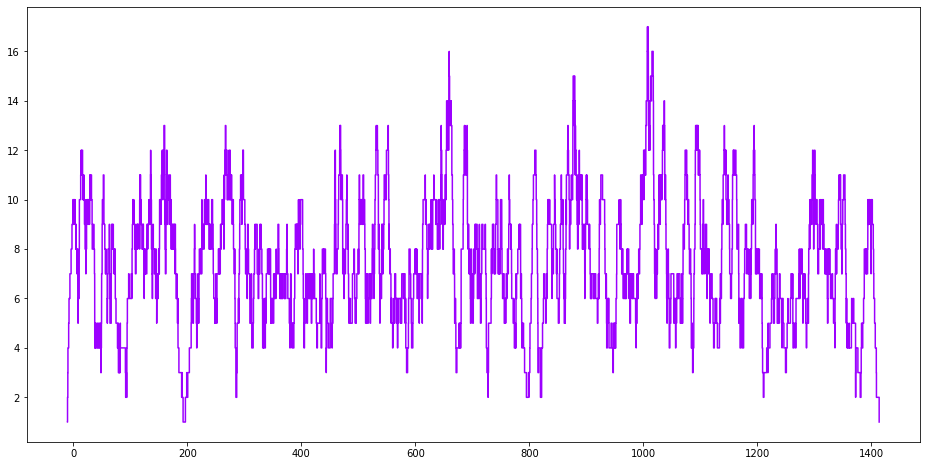

In [4]:
vstepsp = Steps(False).add_direct(dfp.start,dfp.ends)
vstepsp.plot()

In [5]:
#%%timeit -r 20 -n 20
queue = sc.Stairs(use_dates=True).layer(df.enter, df.leave)
queueh = sc.Stairs(use_dates=True).layer(dfh.check_in,dfh.check_out)
queuep = sc.Stairs().layer(dfp.start, dfp.ends)

In [63]:
# def process_row_simple_append(result,start=None,end=None,weight=1,use_datetime = False):
#     if pd.isnull(start):
#         result = np.append(result,[end,-1,weight])
#     elif pd.isnull(end):
#         result = np.append(result,[start,1,weight])
#     else:
#         result = np.append(result,[[start,1,weight],[end,1,-1*weight]])

# def process_row_simple_index(result,idx,start=None,end=None,weight=1,use_datetime = False):
#     if pd.isnull(start):
#         result[idx] = [end,-1,weight]
#     elif pd.isnull(end):
#         result[idx] = [start,1,weight]
#     else:
#         result[idx] = [start,1,weight]
#         result[idx+1] = [end,1,-1*weight]

# #@jit(parallel=True,nogil=True)
# def process_row_simple_total2(start=None,end=None,weight=1,use_datetime = False):
#     for s,e in zip(start,end):
#         if pd.isnull(s): # is None:
#             yield [pd.Timestamp(e), float(e),int(-1),weight]
#         elif pd.isnull(e): # is None:
#             yield [pd.Timestamp(s), float(s),int(1),weight]
#         else:
#             yield [pd.Timestamp(s), float(s),int(1),weight]
#             yield[pd.Timestamp(e), float(e),int(1),-1*weight]

# def process_row_simple_total3(start=None,end=None,weight=1,use_datetime = False):
#     for s,e in zip(start,end):
#         if s.view('float64') == np.datetime64('NaT').view('float64'):
#             yield [float(e),-1,weight]
#         elif e.view('float64') == np.datetime64('NaT').view('float64'):
#             yield [float(s),1,weight]
#         else:
#             yield [float(s),1,weight]
#             yield[float(e),1,-1*weight]

#@jit(parallel=True,nogil=True)
def process_row_simple_loop(start=None,end=None,weight=None,size=0,use_datetime = False):
    #minimum is the start array
    #t = np.dtype([('start', np.float64), ('direction', np.int64), ('weight', np.int64)])
    weight = np.ones(len(start),dtype=np.int32) if weight is None else weight

    if use_datetime:
        end = np.full(len(start),np.datetime64('NaT')) if end is None else end
        check_func = np.isnat
    else:
        end = np.full(len(start),np.float('NaN')) if end is None else end
        check_func = np.isnan   

    result = np.empty((size,3)) 

    k = 0
    for i in range(len(start)):
        if check_func(start[i]) and not check_func(end[i]):
            result[k] = (float(end[i]),-1,weight[i])
            k += 1
        elif check_func(end[i]):
            result[k] = (float(start[i]),1,weight[i])
            k += 1
        else:
            result[k] = (float(start[i]),1,weight[i])
            k += 1
            result[k] = (float(end[i]),1,-1*weight[i])
            k += 1

    return result

def process_row_simple_total_dt(start=None,end=None,weight=None,use_datetime = False):
    #minimum is the start array
    weight = np.ones(len(start),dtype=np.int32) if weight is None else weight
    end = np.full(len(start),None) if end is None else end

    if use_datetime:
        convert_func = date_to_float
    else:
        convert_func = float   

    for s,e,w in zip(start,end,weight):
        if pd.isnull(s) and not pd.isnull(e):
            yield (convert_func(e),-1,w)
        elif pd.isnull(e):
            yield (convert_func(s),1,w)
        else:
            yield (convert_func(s),1,w)
            yield (convert_func(e),1,-1*w)

def process_row_simple_total(start=None,end=None,weight=None,use_datetime = False):
    #minimum is the start array
    #t = np.dtype([('start', np.float64), ('direction', np.int64), ('weight', np.int64)])
    weight = np.ones(len(start),dtype=np.int32) if weight is None else weight

    if use_datetime:
        end = np.full(len(start),np.datetime64('NaT')) if end is None else end
        check_func = np.isnat
    else:
        end = np.full(len(start),np.float('NaN')) if end is None else end
        check_func = np.isnan    

    for s,e,w in zip(start,end,weight):
        if (check_func(s) or s is None) and not (check_func(e) or e is None):
            yield (float(e),-1,w)
        elif check_func(e) or e is None:
            yield (float(s),1,w)
        else:
            yield (float(s),1,w)
            yield (float(e),1,-1*w)

# def process_row_simple(start=None,end=None,weight=1,use_datetime = False):
#     if pd.isnull(start):
#         yield [end,-1,weight]
#     elif pd.isnull(end):
#         yield [start,1,weight]
#     else:
#         yield [start,1,weight]
#         yield[end,1,-1*weight]

# def process_row(start=None,end=None,weight=1,use_datetime = False):
#     if pd.isnull(start):
#         return np.asarray([[*Utils.get_keys(end,is_dt=use_datetime),-1,weight]])
#     elif pd.isnull(end):
#         return np.asarray([[*(Utils.get_keys(start,is_dt=use_datetime)),1,weight]])
#     else:
#         return np.asarray([[*(Utils.get_keys(start,is_dt=use_datetime)),1,weight],[*(Utils.get_keys(end,is_dt=use_datetime)),1,-1*weight]])

# def process_row_row(row,weight=1,use_datetime = False):
#     if pd.isnull(row[0]):
#         return np.asarray([[*Utils.get_keys(pd.Timestamp(row[1]),is_dt=use_datetime),-1,weight]])
#     elif pd.isnull(row[1]):
#         return np.asarray([[*(Utils.get_keys(pd.Timestamp(row[0]),is_dt=use_datetime)),1,weight]])
#     else:
#         return np.asarray([[*(Utils.get_keys(pd.Timestamp(row[0]),is_dt=use_datetime)),1,weight],[*(Utils.get_keys(pd.Timestamp(row[1]),is_dt=use_datetime)),1,-1*weight]])

# def process_row2(start=None,end=None,weight=1,use_datetime = False):
#     if pd.isnull(start):
#         return np.asarray([[*Utils.get_keys(pd.Timestamp(end),is_dt=use_datetime),-1,weight]])
#     elif pd.isnull(end):
#         return np.asarray([[*(Utils.get_keys(pd.Timestamp(start),is_dt=use_datetime)),1,weight]])
#     else:
#         return np.asarray([[*(Utils.get_keys(pd.Timestamp(start),is_dt=use_datetime)),1,weight],[*(Utils.get_keys(pd.Timestamp(end),is_dt=use_datetime)),1,-1*weight]])


In [58]:
pd.isnull(float('nan'))

True

In [ ]:
#%%timeit -r 3 -n 3
df.replace({np.datetime64('NaT'): None},inplace=True)
r = [nprocess_row_simple(s,e,use_datetime=True)) for (s,e) in zip(df.enter,df.leave)]
len(r

In [76]:
%%timeit -r 20 -n 20
#t = np.dtype([('start', np.float64), ('direction', np.int64), ('weight', np.int64)])
r = np.array(list(process_row_simple_total(np.array(df.enter),np.array(df.leave),use_datetime=False)))
r.shape

6.73 ms ± 169 µs per loop (mean ± std. dev. of 20 runs, 20 loops each)


In [75]:
%%timeit -r 20 -n 20
r_loop = np.array(list(process_row_simple_total_dt(np.array(df.enter),np.array(df.leave),use_datetime=True)))
r_loop

6.31 ms ± 259 µs per loop (mean ± std. dev. of 20 runs, 20 loops each)


In [74]:
%%timeit -r 20 -n 20
r = np.array(list(process_row_simple_total(np.array(dfp.start),np.array(dfp.ends),use_datetime=False)))
r

4.84 ms ± 191 µs per loop (mean ± std. dev. of 20 runs, 20 loops each)


In [ ]:
#%%timeit -r 20 -n 20
r = np.array(list(process_row_simple_total(np.array(dfh.check_in),np.array(dfh.check_out),use_datetime=False)))
r.shape

In [42]:
#%%timeit -r 20 -n 20
# a,b = np.array(dfp.start),np.array(dfp.ends)
# np.isnan(a[-2])

a,b = np.array(df.enter),np.array(df.leave)
a[10]
#print(datetime(a[10]),pd.Timestamp(a[10]).timestamp(),int(a[10])/10**9)
#print(pd.Timestamp(a[10]).timestamp(),pd.Timestamp(int(a[10])))
print(10**9*pd.Timestamp(a[10]).timestamp()==float(a[10]))

True


In [ ]:
StepIndexs.WEIGHT.value

In [9]:
#%%timeit -r 10 -n 10
st = Steps(use_datetime=True).add_direct(df.enter,df.leave)
sth = Steps(use_datetime=True).add_direct(dfh.check_in,dfh.check_out)

In [4]:
from dateutil.tz import *
n = df.enter[10].to_datetime64()
d = datetime(2020,1,1,20,47,tzinfo=tzutc())
p = df.enter[10]

tn = float(n)
tsp = p.timestamp()
tsd = d.timestamp()

print(type(p),pd.Timestamp(tsp*10**9))
print(type(n),pd.Timestamp(tn))
print(type(d),pd.Timestamp(tsd*10**9))


<class 'pandas._libs.tslibs.timestamps.Timestamp'> 2020-01-01 20:47:00
<class 'numpy.datetime64'> 2020-01-01 20:47:00
<class 'datetime.datetime'> 2020-01-01 20:47:00


In [6]:
def is_accepted_datetime(value):
    return (hasattr(value,'timestamp') and callable(value.timestamp)) or hasattr(value,'dtype')

def date_to_float(date_value):
    if is_accepted_datetime(date_value):
        if hasattr(date_value,'dtype'):
            return float(date_value)/10.0**9
        else:
            return date_value.timestamp()
    else:
        raise TypeError('Only datetime, numpy.datetime64, Pandas.Timestamp and derived datetime types are valid.')

def float_to_date(float_value):
    return pd.Timestamp(float_value*10.0**9)

In [9]:
isinstance(n,np.datetime64)

True

In [7]:
print(type(p),date_to_float(p),float_to_date(date_to_float(p)))
print(type(n),date_to_float(n),float_to_date(date_to_float(n)))
print(type(d),date_to_float(d),float_to_date(date_to_float(d)))


<class 'pandas._libs.tslibs.timestamps.Timestamp'> 1577911620.0 2020-01-01 20:47:00
<class 'numpy.datetime64'> 1577911620.0 2020-01-01 20:47:00
<class 'datetime.datetime'> 1577911620.0 2020-01-01 20:47:00


<AxesSubplot:>

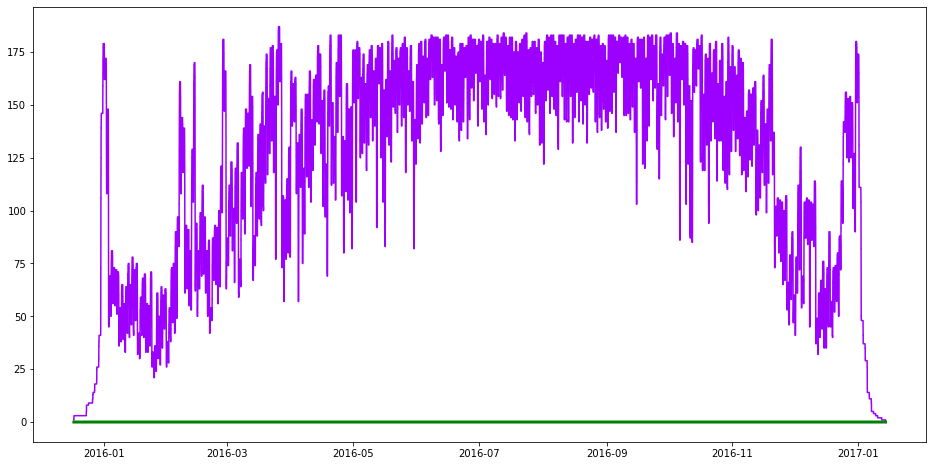

In [10]:
#k = st.step_keys()
#v = st.step_values()
#v = st.smooth_step(k,smooth_factor=1)

#ax = st.plot()
ax = sth.plot()
sth.smooth_plot(ax=ax,color='g',smooth_factor=250000,linewidth=3)
#st.smooth_plot(ax=ax,color='g',smooth_factor=250000,linewidth=3)
#ax.step(Utils.prepare_datetime(k),v,color='g')

In [7]:
k = st.step_keys()
v = st.step_values()
v = st.smooth_step(k)
v[3]
#queue.plot(ax=ax)

16.0

In [ ]:
s = np.asfarray(st._step_np[:,[0,1,2]])
x = Utils.prepare_input(k)
result = st._base(x,s,10)
result

In [ ]:
#%%timeit -r 3 -n 3
vsteps = Steps.read_dataframe(df.head(50),'enter','leave')

In [ ]:
#%%timeit -r 3 -n 3
hotel_stays = Steps.read_dataframe(dfh,'check_in', 'check_out')

In [ ]:
#%%timeit -r 3 -n 3
queue = sc.Stairs(use_dates=True).layer(df.head(50).enter, df.head(50).leave)

In [ ]:
Utils.prepare_datetime(st._all_keys)
st._all_data

In [ ]:
kk = np.unique(vsteps.step_keys())
kv = vsteps(kk)

for i,k in enumerate(queue.step_changes().items()):
    print(k[0],' - ',k[1],' || ', Utils.prepare_datetime(vsteps._all_data[i+1,0]),' - ', vsteps._all_data[i+1,1])

In [ ]:
vtn = vsteps._step_np
k = np.unique(vtn[:,1])
v = vtn[:,3]

vtn[vtn[:,1]==k,:]

In [ ]:
np.asarray(queue(Utils.prepare_datetime(vsteps._all_data[0:,0])))

In [ ]:
vsteps._all_keys

In [ ]:
fig, ax = plt.subplots(figsize=(36,6))
queue.plot(ax=ax)
#ax.step(Utils.prepare_datetime(vsteps._all_data[1:,0]),np.asarray(queue(Utils.prepare_datetime(vsteps._all_data[1:,0]))), color='r')
#ax.step(Utils.prepare_datetime(vsteps._all_data[1:-1,0]),vsteps(vsteps._all_data[2:,0]),color='g')

In [ ]:
def groupby(X, y):
    y = np.asarray(y)
    X = np.asarray(X)
    y_uniques = np.unique(y)
    return np.asarray([[yi, np.sum(X[y==yi])] for yi in y_uniques])

all_values = vsteps._step_np[:,2]*vsteps._step_np[:,3]
all_keys = vsteps._step_np[:,0]
gr = groupby(all_values,all_keys)
gr[0,1]

In [ ]:
from numpy import datetime64

def monkeypatch_method(cls):
    def decorator(func):
        setattr(cls,func.__name__,func)
        return func
    return decorator

#@monkeypatch_method(datetime64)
#def timestamp(self):
#    return (self - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


def NaT_None(data):
    if pd.isna(data):
        return None
    else:
        return data

def create_step(d):
    return Step(use_datetime=True,data=d)


# st = Steps(True)
df2 = df.iloc[0:20]
# df2np = df2[['enter','leave']].to_numpy()
# df2npn = np.where(df2np is datetime64('NaT'),None,df2np)

# sss = np.apply_along_axis(create_step, 1, df2npn)
# sss
#dfc = df2[['enter','leave']].replace(np.datetime64('NaT'),None)
ss = df2.apply(lambda x: Step(use_datetime=True,data=(x['enter'],x['leave'])),axis=1)
#s = Step(data=np.array([None,100]))
print(ss)

In [ ]:
%%timeit -r 3 -n 3
ss = dfh.apply(lambda x: Step(use_datetime=True,data=(x['check_in'],x['check_out'])),axis=1)
#st = Steps(use_datetime=True).add(ss)

In [ ]:
%%timeit -r 3 -n 3
ss = dfh.apply(lambda x: Step(use_datetime=True,data=(NaT_None(x['check_in']),NaT_None(x['check_out']))),axis=1)
#st = Steps(use_datetime=True).add(ss)

In [ ]:
step_dict = vsteps.to_dict()
print(step_dict.keys()[0:3],step_dict.values()[0:3])

In [ ]:
asteps = Steps.read_array(df.head(150).enter, df.head(150).leave,use_datetime=True)
dsteps = Steps.read_dict(step_dict)
step_dict.values()[0]

In [ ]:
df_vsteps = vsteps.to_dataframe() #
df_vsteps.head()

In [ ]:
vsteps_df = Steps.read_dataframe(df_vsteps,'start','end')

In [ ]:
ax = vsteps_df.plot(size=(32,6))
vsteps.plot(ax=ax,color='g')
asteps.plot(ax=ax,color='blue')
dsteps.plot(ax=ax,color='r')
#dsteps.normalise().plot(ax=ax,color='orange')

In [ ]:
d = pd.Timestamp(2020,1,20)
ax = vsteps_df.clip(lbound=d).plot(size=(32,6))
vsteps.clip(lbound=d).plot(ax=ax,color='g')
#asteps.clip(lbound=d).plot(ax=ax,color='blue')
dsteps.clip(lbound=d).plot(ax=ax,color='red')


In [ ]:
dsteps(pd.Timestamp(2020,1,1))

In [ ]:
dfdf = vsteps_df.clip(lbound=pd.Timestamp(2020,1,10),ubound=pd.Timestamp(2020,1,20)) #.to_dataframe(mode='aggregate')
vstep_clipped = vsteps.clip(lbound=pd.Timestamp(2020,1,10),ubound=pd.Timestamp(2020,1,20))
#vstep_clipped.steps()